# Preprocessing of CLL DNA Methylation Data
The experiment was done with human donors. We have blood cells from healthly donors (HD), 

In [22]:
import pandas as pd
import numpy as np
import h5py, os, sys
import mygene
import networkx as nx
import umap

sys.path.append(os.path.abspath('../GCN'))
import gcnPreprocessing
import gcnIO

import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn as sns
%matplotlib inline

## Parameters

In [5]:
# PARAMETERS
ppi_network_to_use ='IREF'
use_only_blood_cancer_genes = True
imputation_threshold = 0.5

## Functions

In [6]:
def get_gene_symbols(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

def get_ensembl_ids(list_of_gene_symbols):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_gene_symbols,
                       scopes='symbol, refseq, uniprot',
                       fields='ensembl.gene',
                       species='human', returnall=True
                      )

    # now, retrieve the names and IDs from a dictionary and put in DF
    def get_name_and_id(x):
        if 'ensembl' in x:
            ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
            symbol = x['query']
            return [symbol, ens_id]
        else:
            return [x['query'], None]

    ens_ids = [get_name_and_id(x) for x in res['out']]
    
    node_names = pd.DataFrame(ens_ids, columns=['Symbol', 'Ensembl_ID']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    node_names.drop_duplicates(inplace=True)
    return node_names

## Load the data and join gene map with DNA methylation

In [7]:
meth_data = pd.read_csv('../data/CLL/all_data.bed', sep='\t')
meth_data.columns = ['chr'] + meth_data.columns[1:].tolist()
cpg2gene_map = pd.read_csv('../data/CLL/pos2gene.txt.gz', sep='\t', compression='gzip', header=None,
                           names=['chr', 'start', 'end', 'gene', 'location'])
meth_data_genenames = meth_data.merge(cpg2gene_map, left_on=['chr', 'start', 'end'], right_on=['chr', 'start', 'end'])
meth_data_genenames.head()

,chr,start,end,HD_1,HD_2,HD_3,HD_4,HD_5,MBL_unmut_1,MBL_unmut_16,...,MBL_2958,MBL_2781,MBL_3036,CLL_2443,CLL_2918,CLL_2958,CLL_2781,CLL_3036,gene,location
0,chr1,10496,10498,0.780,0.820,0.925,1.000,0.885,0.875,1.000,...,0.722,1.000,1.000,0.950,1.000,0.682,1.000,0.966,DDX11L1,promoter
1,chr1,10524,10526,0.959,0.978,1.000,0.958,0.926,1.000,0.983,...,0.985,1.000,1.000,0.979,0.952,0.956,1.000,1.000,DDX11L1,promoter
2,chr1,10541,10543,0.982,0.955,0.964,0.916,0.939,0.960,0.951,...,0.985,0.984,0.976,0.980,0.975,0.985,1.000,1.000,DDX11L1,promoter
3,chr1,10562,10564,0.905,0.922,0.964,0.895,0.839,0.920,0.983,...,0.782,0.809,1.000,0.850,0.951,0.828,0.838,0.984,DDX11L1,promoter
4,chr1,10570,10572,0.976,0.977,0.982,0.937,0.963,0.960,0.983,...,0.985,0.968,0.952,1.000,0.991,0.985,0.983,1.000,DDX11L1,promoter


## Clean Data

In [8]:
# select promoters only
promonly = meth_data_genenames[meth_data_genenames.location == 'promoter']
msg = "Selected only unambigous promoter CpG sites. Left with {} CpG sites for {} genes"
print (msg.format(promonly.shape[0], promonly.gene.nunique()))

# drop CpG sites with more than n percent NAs
na_removed = promonly.dropna(axis=0, thresh=imputation_threshold*(promonly.shape[1]-5))
msg = "Dropped {} (left with {}) CpG sites because they contained too many NAs"
print (msg.format(promonly.shape[0]-na_removed.shape[0], na_removed.shape[0]))

Selected only unambigous promoter CpG sites. Left with 955139 CpG sites for 28707 genes
Dropped 227960 (left with 727179) CpG sites because they contained too many NAs


## Compute Gene $\times$ Sample Matrix and Impute

In [9]:
gene_sample_average = na_removed.drop(['start', 'end', 'chr', 'location'], errors='ignore', axis=1).groupby('gene').mean()

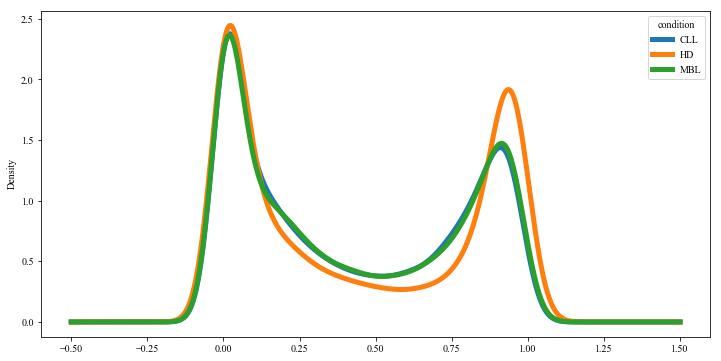

In [10]:
sample_gene_average = gene_sample_average.T
sample_gene_average['condition'] = [i[0] for i in sample_gene_average.index.str.split('_')]
sample_gene_average.groupby('condition').mean().T.plot(kind='kde', figsize=(12, 6), lw=5)

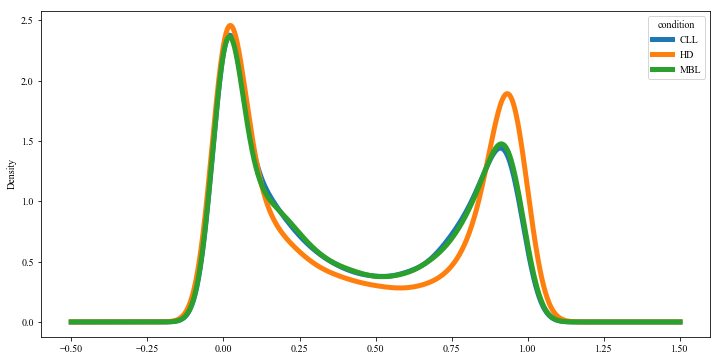

In [12]:
sample_gene_average.drop('condition', axis=1, errors='ignore', inplace=True)
features = sample_gene_average.fillna(sample_gene_average.mean()).T
assert (features.isnull().sum().sum() == 0)

sample_gene_nona = features.T
sample_gene_nona['condition'] = [i[0] for i in sample_gene_nona.index.str.split('_')]
sample_gene_nona.groupby('condition').mean().T.plot(kind='kde', figsize=(12, 6), lw=5)

## Load PPI Network

In [13]:
ppi_network = None
if ppi_network_to_use.upper() == 'IREF':
    net_file = '../data/pancancer/hotnet2/networks/irefindex9/irefindex9_edge_list'
    name_file = '../data/pancancer/hotnet2/networks/irefindex9/irefindex9_index_gene'
    edgelist = pd.read_csv(net_file, sep=' ', header=None,
                           names=['from', 'to', 'weight'])
    index = pd.read_csv(name_file, sep=' ', header=None, names=['name'])
    # build network and relabel nodes to match with real names
    ppi_graph = nx.from_pandas_edgelist(edgelist, source='from', target='to', edge_attr=None)
    _ = nx.relabel_nodes(ppi_graph, index.to_dict()['name'], copy=False)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    symbols_network_genes = get_ensembl_ids(ppi_network.index)
    # Remove nodes from network that don't have corresponding gene names
    nodes_not_translatable = ppi_network[~ppi_network.index.isin(symbols_network_genes.Symbol)].index
    print ("Not translatable: {}".format(nodes_not_translatable.shape[0]))
    ppi_graph.remove_nodes_from(nodes_not_translatable)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    assert ((ppi_network.index == symbols_network_genes.Symbol).all())

elif ppi_network_to_use.upper() == 'CPDB':
    ppi_network = pd.read_csv('../../data/networks/CPDB_symbols_edgelist.tsv', sep='\t')
    ppi_graph = nx.from_pandas_edgelist(df=ppi_network, source='partner1', target='partner2', edge_attr='confidence')
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
else:
    print ("No PPI network named {}".format(ppi_network_to_use))

print ("Edges: {}\tNodes: {}".format(ppi_graph.number_of_edges(), ppi_graph.number_of_nodes()))

#mutations_ppiindex = mutations.reindex(ppi_network.index, fill_value=0)


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12129...done.
Finished.
8 input query terms found dup hits:
	[('AHRR', 2), ('ARMCX5-GPRASP2', 2), ('BIRC8', 2), ('FAM27E3', 2), ('KLRC4-KLRK1', 2), ('MEMO1', 2),
702 input query terms found no hit:
	['ABP1', 'ACCN1', 'ACCN2', 'ACCN3', 'ACCN5', 'ACN9', 'ADCK3', 'ADRBK1', 'ADRBK2', 'AES', 'AGPAT6', '
Not translatable: 0
Edges: 91809	Nodes: 12129


In [14]:
features_ppiindex = features.reindex(ppi_network.index, fill_value=0.5)
genes_without_data = features_ppiindex.shape[0]-features.index.isin(ppi_network.index).sum()
print ("No data for {} / {} genes. Replacing them with 0.5".format(genes_without_data, features_ppiindex.shape[0]))

No data for 2850 / 12129 genes. Replacing them with 0.5


## Get Labels

In [15]:
nodes = get_ensembl_ids(ppi_network.index)
nodes.columns = ['Name']

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12129...done.
Finished.
8 input query terms found dup hits:
	[('AHRR', 2), ('ARMCX5-GPRASP2', 2), ('BIRC8', 2), ('FAM27E3', 2), ('KLRC4-KLRK1', 2), ('MEMO1', 2),
702 input query terms found no hit:
	['ABP1', 'ACCN1', 'ACCN2', 'ACCN3', 'ACCN5', 'ACN9', 'ADCK3', 'ADRBK1', 'ADRBK2', 'AES', 'AGPAT6', '


In [16]:
known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

# load cgc
cgc = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv')
cgc.dropna(subset=['Tissue Type'], inplace=True)

if use_only_blood_cancer_genes:
    # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
    pattern = '|'.join(['E', 'O', 'M', 'E;'])
    blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
    known_cancer_genes_innet = blood_cancer_genes[blood_cancer_genes['Gene Symbol'].isin(nodes.Name)]['Gene Symbol']
    print ("Left with {} known blood cancer genes".format(known_cancer_genes_innet.shape[0]))

Left with 229 known blood cancer genes


In [17]:
print ("{} genes are in network".format(nodes.shape[0]))

# get rid of the positives (known cancer genes)
not_positives = nodes[~nodes.Name.isin(known_cancer_genes_innet)]
print ("{} genes are in network but not in positives (known cancer genes from NCG)".format(not_positives.shape[0]))

# get rid of OMIM genes associated with cancer
omim_cancer_genes = pd.read_csv('../data/pancancer/OMIM/genemap_search_cancer.txt',
                                sep='\t', comment='#', header=0, skiprows=3)
# use fact that nan != nan for filtering out NaN
sublists = [sublist for sublist in omim_cancer_genes['Gene/Locus'].str.split(',') if sublist == sublist]
omim_cancer_geneset = [item.strip() for sublist in sublists for item in sublist]
not_omim_not_pos = not_positives[~not_positives.Name.isin(omim_cancer_geneset)]
print ("{} genes are also not in OMIM cancer genes".format(not_omim_not_pos.shape[0]))

# get rid of all the OMIM disease genes
omim_genes = pd.read_csv('../data/pancancer/OMIM/genemap2.txt', sep='\t', comment='#', header=None)
omim_genes.columns = ['Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Cyto Location',
                      'Computed Cyto Location', 'Mim Number', 'Gene Symbol', 'Gene Name',
                      'Approved Symbol', 'Entrez Gene ID', 'Ensembl Gene ID', 'Comments',
                      'Phenotypes', 'Mouse Gene Symbol/ID']
omim_gene_names = []
for idx, row in omim_genes.iterrows():
    gene_names = row['Gene Symbol'].strip().split(',')
    omim_gene_names += gene_names
omim_gene_names = list(set(omim_gene_names))
not_omim_not_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(omim_gene_names)]
print ("{} genes are in network but not in oncogenes and not in OMIM".format(not_omim_not_pos.shape[0]))

# remove COSMIC cancer gene census genes
cosmic_gene_scores = pd.read_csv('../data/pancancer/cosmic/cancer_gene_census.csv', header=0)
not_omim_cosmic_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes are also not in COSMIC cancer gene census".format(not_omim_cosmic_pos.shape[0]))

# remove COSMIC highly mutated genes
cosmic_prcoding_mutations = pd.read_csv('../data/pancancer/cosmic/CosmicMutantExportCensus.tsv.gz',
                                        compression='gzip', sep='\t')
non_pos_omim_cosmiccgc_cosmic_mutated = not_omim_cosmic_pos[~not_omim_cosmic_pos.Name.isin(cosmic_prcoding_mutations['Gene name'])]
print ("{} genes are also not in COSMIC mutated genes".format(non_pos_omim_cosmiccgc_cosmic_mutated.shape[0]))

# remove genes that belong to KEGG pathways in cancer
kegg_cancer_pathway_genes = pd.read_csv('../data/pancancer/KEGG/KEGG_genes_in_pathways_in_cancer.txt',
                                        skiprows=2, header=None, names=['Name'])
not_pos_omim_cosmic_kegg = non_pos_omim_cosmiccgc_cosmic_mutated[~non_pos_omim_cosmiccgc_cosmic_mutated.Name.isin(kegg_cancer_pathway_genes.Name)]
print ("{} genes are also not in KEGG cancer pathways".format(not_pos_omim_cosmic_kegg.shape[0]))

# get rid of genes that are not candidate cancer genes
negatives = not_pos_omim_cosmic_kegg[~not_pos_omim_cosmic_kegg.Name.isin(candidate_cancer_genes)]
print ("{} genes are also not in NCG candidate cancer genes".format(negatives.shape[0]))

# collect genes in KEGG cancer modules
kegg_cancer_module_genes = []
count = 0
with open('../data/pancancer/KEGG/KEGG_cancer_modules.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_module_genes.append(item.strip())
kegg_cancer_module_genes = list(set(kegg_cancer_module_genes))

# collect genes in KEGG cancer gene neighborhoods
kegg_cancer_neighborhood_genes = []
count = 0
with open('../data/pancancer/KEGG/KEGG_cancer_neighborhoods.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_neighborhood_genes.append(item.strip())
kegg_cancer_neighborhood_genes = list(set(kegg_cancer_neighborhood_genes))

negatives = negatives[~negatives.Name.isin(kegg_cancer_module_genes) & ~negatives.Name.isin(kegg_cancer_neighborhood_genes)]
print ("{} genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods".format(negatives.shape[0]))

12129 genes are in network
11900 genes are in network but not in positives (known cancer genes from NCG)
11873 genes are also not in OMIM cancer genes
2121 genes are in network but not in oncogenes and not in OMIM
2096 genes are also not in COSMIC cancer gene census
2095 genes are also not in COSMIC mutated genes
2088 genes are also not in KEGG cancer pathways
1979 genes are also not in NCG candidate cancer genes
1059 genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods


## Train Test Split

In [18]:
y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)

In [19]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.shape, train_mask.shape, y_test.shape, test_mask.shape, y_val.shape, val_mask.shape

((12129, 1), (12129,), (12129, 1), (12129,), (12129, 1), (12129,))

## Write HDF5 Container

In [20]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.close()

    print ("Container written to {}".format(fname))

In [21]:
nodes['ID'] = nodes.index
nodes = nodes[['ID', 'Name']]
fname = '../data/CLL/methylation_samplewise.h5'
write_hdf5_container(fname, ppi_network.values, features_ppiindex.values, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, features_ppiindex.columns)

Container written to ../data/CLL/methylation_samplewise.h5


## Dimension Reduction

In [40]:
for i in meth_data_promonly.columns[3:]:
    print (i)

HD_1
HD_2
HD_3
HD_4
HD_5
MBL_unmut_1
MBL_unmut_16
MBL_mut_2
MBL_mut_3
MBL_mut_4
MBL_mut_5
MBL_mut_6
MBL_mut_7
MBL_mut_8
MBL_mut_9
MBL_mut_10
MBL_mut_11
MBL_mut_12
MBL_mut_13
MBL_mut_14
MBL_mut_15
MBL_mut_17
MBL_mut_18
MBL_mut_19
MBL_mut_20
CLL_unmut_pre_1A
CLL_unmut_pre_1B
CLL_unmut_pre_1C
CLL_unmut_pre_1D
CLL_unmut_pre_3A
CLL_unmut_pre_3B
CLL_unmut_pre_3C
CLL_unmut_pre_5A
CLL_unmut_pre_5B
CLL_unmut_pre_5C
CLL_unmut_pre_5D
CLL_unmut_post_5E
CLL_unmut_pre_6A
CLL_unmut_pre_6B
CLL_unmut_pre_6C
CLL_unmut_pre_11A
CLL_unmut_pre_11B
CLL_unmut_post_11D
CLL_unmut_post_11E
CLL_unmut_pre_12A
CLL_unmut_pre_12B
CLL_unmut_pre_13A
CLL_unmut_pre_13B
CLL_unmut_post_13C
CLL_unmut_post_13D
CLL_unmut_pre_14A
CLL_unmut_pre_14B
CLL_unmut_post_14C
CLL_unmut_pre_15A
CLL_unmut_pre_15B
CLL_unmut_pre_15C
CLL_unmut_post_15D
CLL_unmut_pre_21A
CLL_unmut_pre_21B
CLL_mut_pre_2A
CLL_mut_pre_2B
CLL_mut_pre_2C
CLL_mut_pre_4A
CLL_mut_pre_4B
CLL_mut_pre_4C
CLL_mut_pre_4D
CLL_mut_pre_7A
CLL_mut_pre_7B
CLL_mut_pre_7C
CLL_mu

In [30]:
sample_gene_average = gene_sample_average.T
sample_gene_average['condition'] = [i[0] for i in sample_gene_average.index.str.split('_')]
def _get_agressiveness(name):
    if 'unmut' in name.split('_')[1]:
        return 'unmut' 
    elif name.split('_')[1] == 'mut':
        return 'mut'
    else:
        return None
sample_gene_average['aggressiveness'] = [_get_agressiveness(i) for i in sample_gene_average.index]

def _get_treatment(name):
    i = name.split('_')
    if len(i) > 2:
        if i[2] in ['pre', 'post']:
            return i[2]
    return None
sample_gene_average['treatment'] = [_get_treatment(i) for i in sample_gene_average.index]
def _get_patient_and_timepoint(name):
    val = name.split('_')[-1]
    timepoint = None
    if val[-1].upper() in ['A', 'B', 'C', 'D', 'E', 'F']:
        timepoint = val[-1]
        val = val[:-1]
    return val, timepoint
sample_gene_average['patient'] = [_get_patient_and_timepoint(i)[0] for i in sample_gene_average.index]
sample_gene_average['timepoint'] = [_get_patient_and_timepoint(i)[1] for i in sample_gene_average.index]
sample_gene_average.head()

gene,5S_rRNA,7SK,A1BG,A1BG-AS1,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,A4GALT,AAAS,...,snoU109,snoU13,snoU83B,snoZ6,snosnR60_Z15,condition,aggressiveness,treatment,patient,timepoint
HD_1,0.868138,0.232924,0.854250,0.017617,0.274636,0.933833,0.974909,0.919000,0.9545,0.056716,...,0.232600,0.676746,1.0000,0.921534,0.93175,HD,None,None,1,None
HD_2,0.875211,0.218803,0.694000,0.018895,0.177744,0.969250,0.903727,1.000000,0.4000,0.053429,...,0.220783,0.625546,0.9285,0.895711,0.92850,HD,None,None,2,None
HD_3,0.937371,0.220385,0.916500,0.005341,0.191903,0.936111,0.909375,NaN,NaN,0.032037,...,0.087919,0.580229,0.8570,0.905154,NaN,HD,None,None,3,None
HD_4,0.910809,0.192460,0.770500,0.008864,0.121143,0.970000,0.870333,NaN,0.9165,0.057971,...,0.107714,0.646062,NaN,0.919119,0.96875,HD,None,None,4,None
HD_5,0.878263,0.219848,0.630333,0.012372,0.243447,0.926846,0.918600,0.944333,0.6995,0.062035,...,0.218705,0.644862,1.0000,0.942074,0.85700,HD,None,None,5,None


In [36]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(features_ppiindex.T)

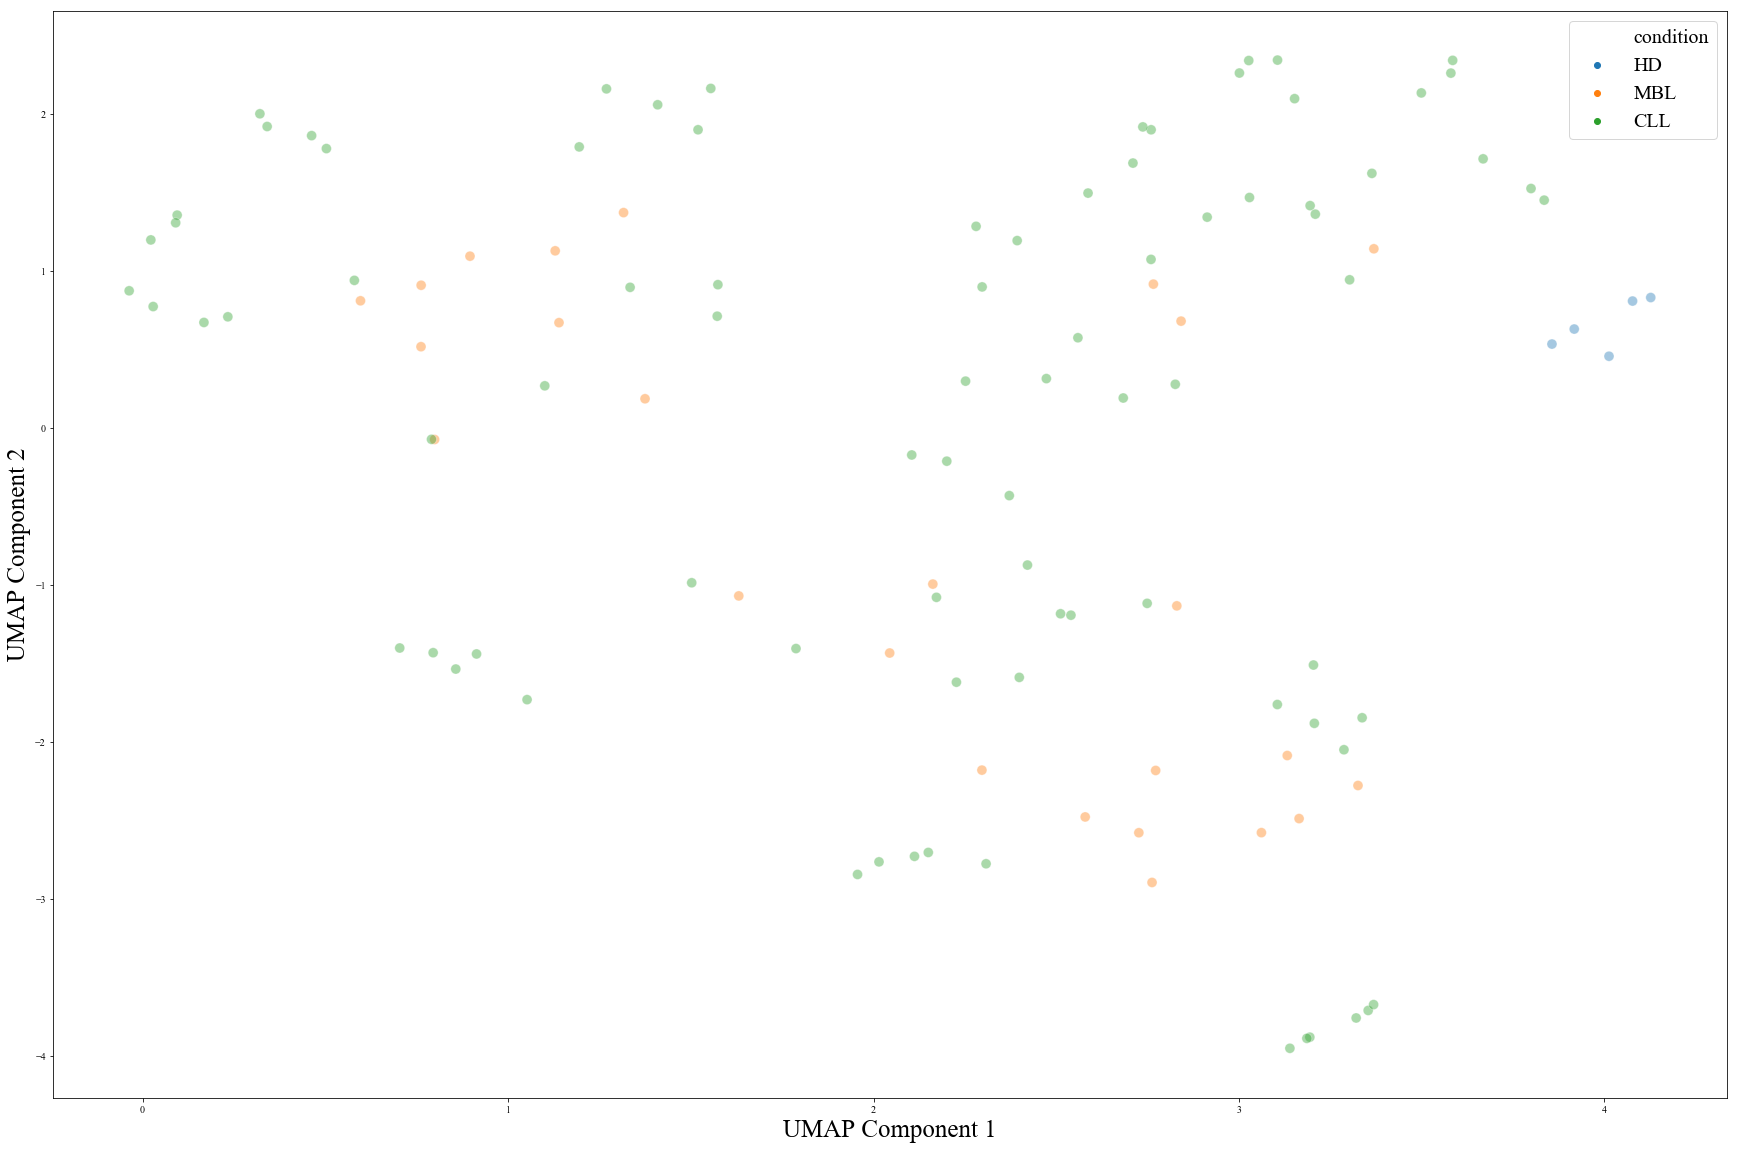

In [41]:
emb_df = pd.DataFrame(embedding, index=features_ppiindex.columns, columns=['PC1', 'PC2'])
emb_df['condition'] = sample_gene_average.condition
emb_df['timepoint'] = sample_gene_average.timepoint
fig = plt.figure(figsize=(30, 20))
g = sns.scatterplot(data=emb_df, x='PC1', y='PC2', hue='condition',
                    alpha=0.4, s=100)
g.set_xlabel('UMAP Component 1', fontsize=25)
g.set_ylabel('UMAP Component 2', fontsize=25)
legend = plt.legend(fontsize=20)
#legend.texts[0].set_text(r"$\bf{Tissue}$")
#legend.texts[17].set_text(r"$\bf{Type}$")
#g.set_title('UMAP Embedding (Tumor, Normal, GTEx) for RSEM read counts (no normalization)', fontsize=35)